In [67]:
import backtrader as bt
import pandas as pd
import numpy as np
import datetime
from copy import deepcopy
from datas import *

# 一、数据准备

## 1.1 读取日度行情表

表内字段就是 Backtrader 默认情况下要求输入的 7 个字段： 'datetime' 、'open'、'high'、'low'、'close'、'volume'、'openinterest'，外加一个 'sec_code' 股票代码字段。

In [109]:
year = 2021
list_assets, df_assets = get_hs300_stocks(f'{year}-01-01')
df_org= get_all_date_data(f'{year}-01-01', f'{year+1}-01-01', list_assets)
df1 = df_org.rename(columns={
        "date": "datetime", 
        "asset": "sec_code"})
df1["openinterest"] = 0
daily_price=df1[['sec_code','datetime', "open", "close", "high", "low", "volume", 'openinterest']]
daily_price['datetime'] = pd.to_datetime(daily_price['datetime'])

# 以 datetime 为 index，类型为 datetime 或 date 类型，Datafeeds 默认情况下是将 index 匹配给 datetime 字段；
daily_price = daily_price.set_index(['datetime'])
daily_price

login success!
login respond error_code:0
login respond  error_msg:success
query_hs300 error_code:0
query_hs300  error_msg:success
logout success!
300


<ipython-input-109-8c1e2acb5d46>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_price['datetime'] = pd.to_datetime(daily_price['datetime'])


,sec_code,open,close,high,low,volume,openinterest
datetime,,,,,,,
2021-01-04,600000,9.64,9.69,9.73,9.55,629069,0
2021-01-05,600000,9.68,9.68,9.68,9.52,538592,0
2021-01-06,600000,9.62,9.82,9.83,9.62,618813,0
2021-01-07,600000,9.83,9.81,9.93,9.66,570904,0
2021-01-08,600000,9.83,9.83,9.90,9.73,558015,0
...,...,...,...,...,...,...,...
2021-12-27,300676,89.32,89.87,90.20,89.03,21026,0
2021-12-28,300676,89.87,88.65,90.30,88.42,27472,0
2021-12-29,300676,88.66,88.19,89.70,88.10,30774,0


## 1.2 生成调仓信息表

表内数据说明：

+ trade_date： 调仓期（每月最后一个交易日）;

+ sec_code：持仓成分股；

+ weight：持仓权重。

In [110]:
from alphalens.utils import get_clean_factor_and_forward_returns
from alphalens.tears import create_full_tear_sheet

df_2 = df_org[['date', 'asset', "close"]]
df_2['date'] = pd.to_datetime(df_2['date'])
# print(df_all)

close = df_2.pivot(index='date', columns='asset', values='close')

alpha_num = 83
alpha_name = 'Alphas101'

# 读取已经计算好的因子
alpha = pd.read_csv('alphas/{}/{}/alpha{:03d}.csv'.format(alpha_name, year, alpha_num))

# 筛选出今年的数据，需与股票收盘日期区间一致
alpha = alpha[(alpha['date'] >= f'{year}-01-01') & (alpha['date'] <= f'{year+1}-01-01')]

# 因子矩阵转换为一维数据(alphalens需要的格式)
alpha = alpha.melt(id_vars=['date'], var_name='asset', value_name='factor' )

# date列转为日期格式
alpha['date'] = pd.to_datetime(alpha['date'])
alpha = alpha[['date', 'asset', 'factor']]

# 设置二级索引
alpha = alpha.set_index(['date', 'asset'], drop=True)
alpha.sort_index(inplace=True)


ret = get_clean_factor_and_forward_returns(alpha, close,quantiles=5)
ret = ret.reset_index()
ret = ret[ret['factor_quantile'] == 5]
ret = ret[['date','asset']]
ret['weight'] = 1/60
trade_info = ret.rename(columns={
        "date": "trade_date", 
        "asset": "sec_code"})
trade_info

<ipython-input-110-3029e40aae47>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['date'] = pd.to_datetime(df_2['date'])


Dropped 4.5% entries from factor data: 4.5% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


,trade_date,sec_code,weight
0,2021-01-04,000001,0.016667
4,2021-01-04,000069,0.016667
8,2021-01-04,000333,0.016667
17,2021-01-04,000656,0.016667
19,2021-01-04,000671,0.016667
...,...,...,...
69614,2021-12-17,603369,0.016667
69616,2021-12-17,603501,0.016667
69618,2021-12-17,603799,0.016667
69621,2021-12-17,603986,0.016667


# 二、 回测分析

## 2.1 加载策略和数据

In [111]:
# 回测策略
class TestStrategy(bt.Strategy):
    params = (
        ('buy_stocks', None), # 传入各个调仓日的股票列表和相应的权重
    )
    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print(f'{dt.isoformat()}, {txt}')

    def __init__(self):
         # 读取调仓日期，即每月的最后一个交易日，回测时，会在这一天下单，然后在下一个交易日，以开盘价买入
        self.trade_dates = pd.to_datetime(self.p.buy_stocks['trade_date'].unique()).tolist()
        self.buy_stock = self.p.buy_stocks # 保留调仓信息
        self.order_list = []  # 记录以往订单，在调仓日要全部取消未成交的订单
        self.buy_stocks_pre = [] # 记录上一期持仓
    
    def next(self):
        # 获取当前的回测时间点
        dt = self.datas[0].datetime.date(0)
        # 打印当前时刻的总资产
        self.log('当前总资产 %.2f' %(self.broker.getvalue()))
        # 如果是调仓日，则进行调仓操作
        if dt in self.trade_dates:
            print(f"--------------{dt} 为调仓日----------")
            #取消之前所下的没成交也未到期的订单
            if len(self.order_list) > 0:
                print("--------------- 撤销未完成的订单 -----------------")
                for od in self.order_list:
                    # 如果订单未完成，则撤销订单
                    self.cancel(od) 
                 #重置订单列表
                self.order_list = [] 

            # 提取当前调仓日的持仓列表
            buy_stocks_data = self.buy_stock.query(f"trade_date=='{dt}'")
            long_list = buy_stocks_data['sec_code'].tolist()
            print('long_list', long_list)  # 打印持仓列表

            # 对现有持仓中，调仓后不再继续持有的股票进行卖出平仓
            sell_stock = [i for i in self.buy_stocks_pre if i not in long_list]
            print('sell_stock', sell_stock)
            if sell_stock:
                print("-----------对不再持有的股票进行平仓--------------")
                for stock in sell_stock:
                    data = self.getdatabyname(stock)
                    if self.getposition(data).size > 0 :
                        od = self.close(data=data)  
                        self.order_list.append(od) # 记录卖出订单

            # 买入此次调仓的股票：多退少补原则
            print("-----------买入此次调仓期的股票--------------")
            for stock in long_list:
                w = buy_stocks_data.query(f"sec_code=='{stock}'")['weight'].iloc[0] # 提取持仓权重
                data = self.getdatabyname(stock)
                order = self.order_target_percent(data=data, target=w*0.95) # 为减少可用资金不足的情况，留 5% 的现金做备用
                self.order_list.append(order)

            self.buy_stocks_pre = long_list  # 保存此次调仓的股票列表
        
    #订单日志    
    def notify_order(self, order):
        # 未被处理的订单
        if order.status in [order.Submitted, order.Accepted]:
            return
        # 已被处理的订单
        if order.status in [order.Completed, order.Canceled, order.Margin]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, ref:%.0f, Price: %.2f, Cost: %.2f, Comm %.2f, Size: %.2f, Stock: %s' %
                    (order.ref,
                     order.executed.price,
                     order.executed.value,
                     order.executed.comm,
                     order.executed.size,
                     order.data._name))
            else:  # Sell
                self.log('SELL EXECUTED, ref:%.0f, Price: %.2f, Cost: %.2f, Comm %.2f, Size: %.2f, Stock: %s' %
                        (order.ref,
                         order.executed.price,
                         order.executed.value,
                         order.executed.comm,
                         order.executed.size,
                         order.data._name))

# 实例化大脑
cerebro_ = bt.Cerebro() 

# 按股票代码，依次循环传入数据
for stock in daily_price['sec_code'].unique():
    # 日期对齐
    data = pd.DataFrame(index=daily_price.index.unique())
    df = daily_price.query(f"sec_code=='{stock}'")[['open','high','low','close','volume','openinterest']]
    data_ = pd.merge(data, df, left_index=True, right_index=True, how='left')
    data_.loc[:,['volume','openinterest']] = data_.loc[:,['volume','openinterest']].fillna(0)
    data_.loc[:,['open','high','low','close']] = data_.loc[:,['open','high','low','close']].fillna(method='pad')
    # data_.loc[:,['open','high','low','close']] = data_.loc[:,['open','high','low','close']].fillna(0)
    datafeed = bt.feeds.PandasData(dataname=data_, fromdate=datetime.datetime(year,1,1), todate=datetime.datetime(year+1,1,1))
    cerebro_.adddata(datafeed, name=stock)
    print(f"{stock} Done !") 

600000 Done !
600004 Done !
600009 Done !
600010 Done !
600011 Done !
600015 Done !
600016 Done !
600018 Done !
600019 Done !
600025 Done !
600027 Done !
600028 Done !
600029 Done !
600030 Done !
600031 Done !
600036 Done !
600048 Done !
600050 Done !
600061 Done !
600066 Done !
600068 Done !
600085 Done !
600104 Done !
600109 Done !
600111 Done !
600115 Done !
600118 Done !
600150 Done !
600161 Done !
600176 Done !
600177 Done !
600183 Done !
600196 Done !
600208 Done !
600233 Done !
600271 Done !
600276 Done !
600297 Done !
600299 Done !
600309 Done !
600332 Done !
600340 Done !
600346 Done !
600352 Done !
600362 Done !
600369 Done !
600383 Done !
600390 Done !
600406 Done !
600436 Done !
600438 Done !
600482 Done !
600487 Done !
600489 Done !
600498 Done !
600519 Done !
600522 Done !
600547 Done !
600570 Done !
600584 Done !
600585 Done !
600588 Done !
600600 Done !
600606 Done !
600637 Done !
600655 Done !
600660 Done !
600690 Done !
600703 Done !
600705 Done !
600741 Done !
600745

## 2.2 添加分析器并执行回测

In [112]:
cerebro = deepcopy(cerebro_)  # 深度复制已经导入数据的 cerebro_，避免重复导入数据 
# 初始资金 100,000,000    
cerebro.broker.setcash(100000.0) 
# 添加策略
cerebro.addstrategy(TestStrategy, buy_stocks=trade_info) # 通过修改参数 buy_stocks ，使用同一策略回测不同的持仓列表

# 添加分析指标
# 返回年初至年末的年度收益率
cerebro.addanalyzer(bt.analyzers.AnnualReturn, _name='_AnnualReturn')
# 计算最大回撤相关指标
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='_DrawDown')
# 计算年化收益
cerebro.addanalyzer(bt.analyzers.Returns, _name='_Returns', tann=252)
# 计算年化夏普比率
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='_SharpeRatio', timeframe=bt.TimeFrame.Days, annualize=True, riskfreerate=0) # 计算夏普比率
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name='_SharpeRatio_A')
# 返回收益率时序
cerebro.addanalyzer(bt.analyzers.TimeReturn, _name='_TimeReturn')

# 启动回测
result = cerebro.run()

2021-01-04, 当前总资产 100000.00
--------------2021-01-04 为调仓日----------
long_list ['000001', '000069', '000333', '000656', '000671', '000895', '001979', '002044', '002129', '002146', '002410', '002607', '002773', '002841', '300003', '300015', '300122', '300144', '300601', '300628', '600031', '600048', '600066', '600104', '600161', '600276', '600299', '600369', '600383', '600406', '600570', '600606', '600660', '600741', '600763', '600795', '600809', '600900', '600918', '600926', '600958', '601100', '601155', '601162', '601166', '601336', '601577', '601696', '601788', '601838', '601878', '601888', '601901', '603019', '603156', '603259', '603288', '603658', '603833', '688008']
sell_stock []
-----------买入此次调仓期的股票--------------
2021-01-05, BUY EXECUTED, ref:181119, Price: 18.40, Cost: 1564.00, Comm 0.00, Size: 85.00, Stock: 000001
2021-01-05, BUY EXECUTED, ref:181120, Price: 6.87, Cost: 1573.23, Comm 0.00, Size: 229.00, Stock: 000069
2021-01-05, BUY EXECUTED, ref:181121, Price: 98.07, Cost: 147

## 2.3 回测结果分析

,年度,收益率,日均收益率,年化收益率,最大回撤(%),夏普比率
0,2021,0.309471,0.001274,0.378413,-10.8384,1.639796


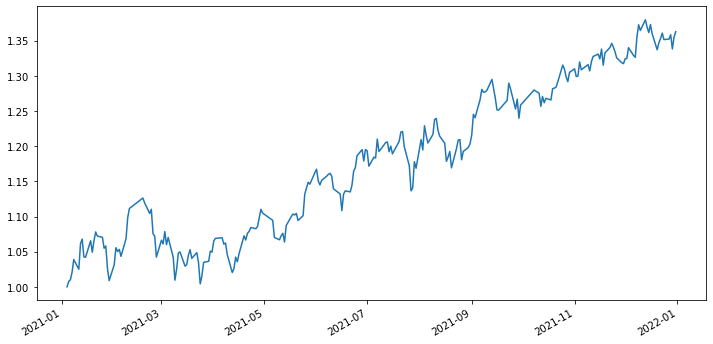

In [114]:
strat = result[0]
# print("--------------- AnnualReturn -----------------")
# print(strat.analyzers._AnnualReturn.get_analysis())
# print("--------------- DrawDown -----------------")
# print(strat.analyzers._DrawDown.get_analysis())
# print("--------------- Returns -----------------")
# print(strat.analyzers._Returns.get_analysis())
# print("--------------- SharpeRatio -----------------")
# print(strat.analyzers._SharpeRatio.get_analysis())
# print("--------------- SharpeRatio_A -----------------")
# print(strat.analyzers._SharpeRatio_A.get_analysis())

# 绘制累计收益率
ret = pd.Series(strat.analyzers._TimeReturn.get_analysis())
(ret + 1).cumprod().plot(figsize=(12,6))

ret = [{
        '年度': year,
        '收益率': strat.analyzers._Returns.get_analysis()['rtot'],
        '日均收益率': strat.analyzers._Returns.get_analysis()['ravg'],
        '年化收益率': strat.analyzers._Returns.get_analysis()['rnorm'],
        '最大回撤(%)': strat.analyzers._DrawDown.get_analysis()['max']['drawdown']
        * (-1),
        '夏普比率': strat.analyzers._SharpeRatio.get_analysis()['sharperatio'],
    }]
pd.DataFrame(ret).sort_values(by='年化收益率', ascending=False)